In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler

## Énoncé
L'agence "Santé publique France" a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. Nous souhaitons y participer et proposer une idée d’application.
## Mission
Nous allons réaliser dans un premier temps un nettoyage et une exploration des données extrait de l’appel à projets.

## Idée d’application
Notre idée d'application consitera à aider un diabétique résident en France à choisir des produits bénéfiques pour son état de santé.Un diabetscore sera ainsi créer pour classer les produits en fonction de leur caractère bénéfique ou non pour le diabète.

## Filtrage des features et produits

Lecture du jeu de données:

In [2]:
df_food = pd.read_csv('fr.openfoodfacts.org.products.csv',sep='\t')

C:\Users\33624\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Un aperçu du jeu de données:

In [3]:
df_food.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Sa taille:

In [4]:
print ("Le jeu de données compte {} lignes et {} variables".format(df_food.shape[0], df_food.shape[1]))

Le jeu de données compte 320772 lignes et 162 variables


Listons les variables numériques:

In [5]:
df_food_num = df_food.select_dtypes(include = ['float64', 'int64'])
df_food_num.columns

Index(['no_nutriments', 'additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil', 'nutrition_grade_uk',
       'energy_100g', 'energy-from-fat_100g', 'fat_100g',
       ...
       'ph_100g', 'fruits-vegetables-nuts_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=106)

Listons les variables catégorielles:

In [6]:
df_food_string =df_food.select_dtypes(include = ['O'])
df_food_string.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands',
       'brands_tags', 'categories', 'categories_tags', 'categories_fr',
       'origins', 'origins_tags', 'manufacturing_places',
       'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr',
       'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities',
       'cities_tags', 'purchase_places', 'stores', 'countries',
       'countries_tags', 'countries_fr', 'ingredients_text', 'allergens',
       'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size',
       'additives', 'additives_tags', 'additives_fr',
       'ingredients_from_palm_oil_tags',
       'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_fr',
       'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_fr',
       'main_category', 'main_category_fr', 'i

 Affichons le nombre de valeurs manquantes par variable:

In [7]:
df_food.isna().sum()

code                           23
url                            23
creator                         2
created_t                       3
created_datetime                9
                            ...  
carbon-footprint_100g      320504
nutrition-score-fr_100g     99562
nutrition-score-uk_100g     99562
glycemic-index_100g        320772
water-hardness_100g        320772
Length: 162, dtype: int64

Regardons à présent les variables qui comptent le plus de valeurs nulles:

Définissons une fonction qui calcule le pourcentage des valeurs nulles:

In [10]:
def null_factor(df, tx):
    null_rate = ((df.isnull().sum() / df.shape[0])*100).sort_values(ascending=False).reset_index()
    null_rate.columns = ['Variable','Taux_de_Null']
    high_null_rate = null_rate[null_rate.Taux_de_Null >= tx]
    return high_null_rate

Affichons les variables ayant le plus de valeurs nulles:

In [11]:
full_null_rate = null_factor(df_food, 100)
full_null_rate

,Variable,Taux_de_Null
0,water-hardness_100g,100.0
1,no_nutriments,100.0
2,ingredients_that_may_be_from_palm_oil,100.0
3,nutrition_grade_uk,100.0
4,nervonic-acid_100g,100.0
5,erucic-acid_100g,100.0
6,mead-acid_100g,100.0
7,elaidic-acid_100g,100.0
8,butyric-acid_100g,100.0
9,caproic-acid_100g,100.0


Affichons le taux de remplissage des variables et afin d'avoir un jeu de données pertinent pour notre analyse, nous décidons de ne considérer que les variables ayant un taux de remplissage supérieur ou egal à 50%.

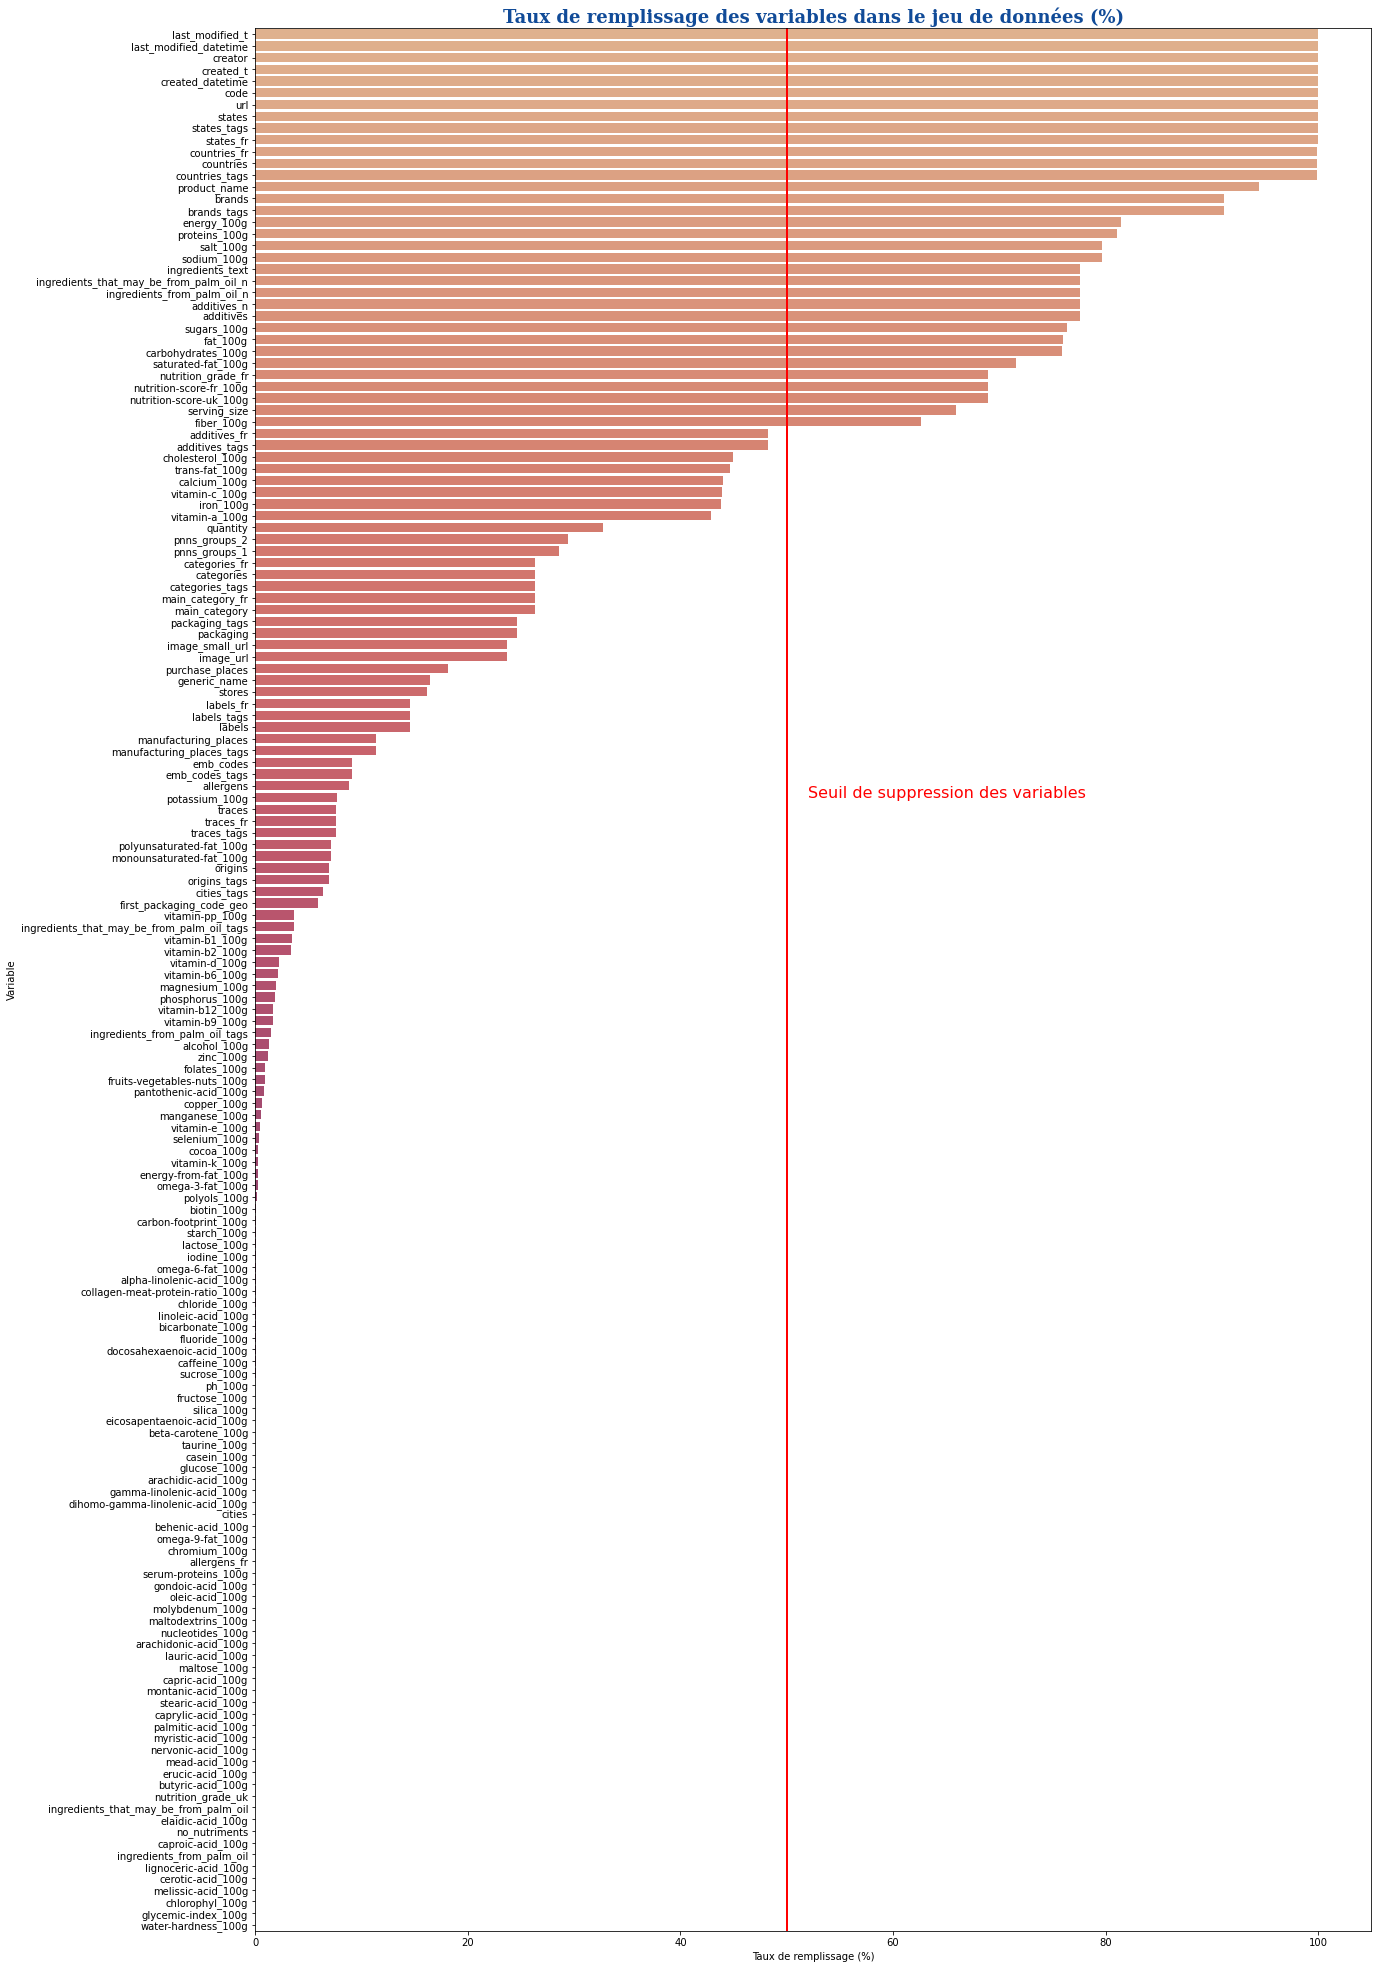

In [12]:
filling_features = null_factor(df_food, 0)
filling_features["Taux_de_remplissage"] = 100-filling_features["Taux_de_Null"]
filling_features = filling_features.sort_values("Taux_de_remplissage", ascending=False) 

#Seuil de suppression
sup_threshold = 50

fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x="Taux_de_remplissage", y="Variable", data=filling_features, palette="flare")
#Seuil pour suppression des varaibles
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.show()

Liste des variables à conserver:

In [13]:
features_to_conserve = list(filling_features.loc[filling_features['Taux_de_remplissage']>=sup_threshold, 'Variable'].values)
df_food_50 = df_food[features_to_conserve].sort_values(["created_datetime","last_modified_datetime"], ascending=True)
df_food_50.columns 

Index(['last_modified_t', 'last_modified_datetime', 'creator', 'created_t',
       'created_datetime', 'code', 'url', 'states', 'states_tags', 'states_fr',
       'countries_fr', 'countries', 'countries_tags', 'product_name', 'brands',
       'brands_tags', 'energy_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'ingredients_text',
       'ingredients_that_may_be_from_palm_oil_n',
       'ingredients_from_palm_oil_n', 'additives_n', 'additives',
       'sugars_100g', 'fat_100g', 'carbohydrates_100g', 'saturated-fat_100g',
       'nutrition_grade_fr', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'serving_size', 'fiber_100g'],
      dtype='object')

Vérifions s'il existe des doublons sur le code du produit qui un identifiant unique:

In [14]:
df_food_50.duplicated('code').sum()

133

Supprimons les doublons en conservant les valeurs nulles:

In [15]:
df_food_50 = df_food_50[~(df_food_50.duplicated('code',keep='last')) | (df_food_50['code'].isnull())]

Conservons les features nutritionnelles et catégorielles des produits utiles à notre problématique:

In [16]:
df_food_50=df_food_50[[ 'code','product_name', 'countries_fr', 'energy_100g', 'fat_100g','saturated-fat_100g', 
                       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
                       'nutrition_grade_fr','nutrition-score-fr_100g']]

Ajoutons les features catégorielles utiles pour catégoriser les produits:

In [17]:
df_food_50['pnns_groups_1']=df_food['pnns_groups_1']
df_food_50['pnns_groups_2']=df_food['pnns_groups_2']

En rapport avec notre problématique(diabétique résident en France nous allons considérer que les produits qu'on pourra trouver en France:

In [18]:
choosen_France = df_food_50['countries_fr'].str.contains('France',case=False,na=False)
df_food_50['countries_fr']=df_food_50[choosen_France ]['countries_fr']
df_food_50=df_food_50[~((df_food_50.countries_fr.isnull()))]

Un aperçu de la variable countries_fr:

In [19]:
df_food_50['countries_fr'].head()


251761                           France
188901                           France
212131                           France
195704                           France
302186    Belgique,France,Italie,Suisse
Name: countries_fr, dtype: object

#### Les catégories de produits

Affichons les catégories présentes dans pnns_groups_1 et pnns_groups_2:

In [20]:
df_food_50['pnns_groups_1'].unique()

array(['Sugary snacks', 'Salty snacks', 'Beverages', 'Fish Meat Eggs',
       'Composite foods', 'Milk and dairy products',
       'Cereals and potatoes', 'Fruits and vegetables', 'Fat and sauces',
       'unknown', nan, 'sugary-snacks', 'fruits-and-vegetables',
       'cereals-and-potatoes'], dtype=object)

In [21]:
df_food_50['pnns_groups_2'].unique()

array(['Sweets', 'Appetizers', 'Biscuits and cakes',
       'Non-sugared beverages', 'Chocolate products', 'Fish and seafood',
       'One-dish meals', 'Cheese', 'Fruit juices', 'Cereals',
       'Fruit nectars', 'Dried fruits', 'Eggs', 'Sweetened beverages',
       'Fats', 'Bread', 'Processed meat', 'Dressings and sauces',
       'Legumes', 'unknown', 'Ice cream', 'Fruits', 'Alcoholic beverages',
       'Milk and yogurt', 'Vegetables', 'Breakfast cereals',
       'Pizza pies and quiche', 'Artificially sweetened beverages',
       'Nuts', 'pastries', 'Meat', 'vegetables', 'Soups',
       'Dairy desserts', 'Sandwich', 'fruits', 'Potatoes', 'Tripe dishes',
       nan, 'Salty and fatty products', 'cereals', 'legumes'],
      dtype=object)

Afin de pourvoir caractériser tous les produits, nous décidons de remplaçer les valeurs manquantes par la catégorie unknown:

In [22]:
df_food_50.loc[df_food_50['pnns_groups_1'].isna(),'pnns_groups_1']='unknown'
df_food_50.loc[df_food_50['pnns_groups_2'].isna(),'pnns_groups_2']='unknown'

Nous identifions des erreurs de formatage par exemple "Fruits and vegetables" et "fruits-and-vegetables".     
Nous allons corriger le problème en passant le texte en miniscule et en remplaçant les caractères spéciaux par un espace :

In [23]:
df_food_50["pnns_groups_1"] = df_food_50["pnns_groups_1"].str.lower().str.replace('-', ' ')
df_food_50["pnns_groups_2"] = df_food_50["pnns_groups_2"].str.lower().str.replace('-', ' ')

Affichons les catégories résultantes de ces corrections:

In [24]:
print("{} catégories sont représentées dans la variable pnns_group_1:".format(len(df_food_50['pnns_groups_1'].unique())))
df_food_50['pnns_groups_1'].unique()

10 catégories sont représentées dans la variable pnns_group_1:


array(['sugary snacks', 'salty snacks', 'beverages', 'fish meat eggs',
       'composite foods', 'milk and dairy products',
       'cereals and potatoes', 'fruits and vegetables', 'fat and sauces',
       'unknown'], dtype=object)

In [25]:
print("{} catégories sont représentées dans la variable pnns_group_2:".format(len(df_food_50['pnns_groups_2'].unique())))
df_food_50['pnns_groups_2'].unique()

37 catégories sont représentées dans la variable pnns_group_2:


array(['sweets', 'appetizers', 'biscuits and cakes',
       'non sugared beverages', 'chocolate products', 'fish and seafood',
       'one dish meals', 'cheese', 'fruit juices', 'cereals',
       'fruit nectars', 'dried fruits', 'eggs', 'sweetened beverages',
       'fats', 'bread', 'processed meat', 'dressings and sauces',
       'legumes', 'unknown', 'ice cream', 'fruits', 'alcoholic beverages',
       'milk and yogurt', 'vegetables', 'breakfast cereals',
       'pizza pies and quiche', 'artificially sweetened beverages',
       'nuts', 'pastries', 'meat', 'soups', 'dairy desserts', 'sandwich',
       'potatoes', 'tripe dishes', 'salty and fatty products'],
      dtype=object)

La taille du nouveau jeu de données: 

In [26]:
print ("Le jeu de données compte {} lignes et {} variables".format(df_food_50.shape[0], df_food_50.shape[1]))

Le jeu de données compte 98425 lignes et 16 variables


Un aperçu du jeu de données:

In [27]:
df_food_50.head()

,code,product_name,countries_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_grade_fr,nutrition-score-fr_100g,pnns_groups_1,pnns_groups_2
251761,3760029248001,Caramels tendres au beurre salé au sel de Guér...,France,1717.0,10.9,7.0,73.5,49.3,NaN,3.0,1.7000,0.669291,e,28.0,sugary snacks,sweets
188901,3029330062806,Jacquet Les bouchées créatives à garnir,France,1898.0,15.5,1.3,68.0,2.0,3.0,8.5,1.7526,0.690000,c,9.0,salty snacks,appetizers
212131,3257980112590,Boudoirs,France,1637.0,3.2,0.9,81.0,55.3,1.5,7.6,0.3810,0.150000,d,13.0,sugary snacks,biscuits and cakes
195704,3160181210524,Cookies tout chocolat Biocoop,France,2040.0,25.0,14.0,56.0,33.0,5.5,7.0,0.3810,0.150000,e,19.0,sugary snacks,biscuits and cakes
302186,8002270014901,Eau minérale gazeuse,"Belgique,France,Italie,Suisse",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,beverages,non sugared beverages


## Traitement des valeurs aberrantes

In [28]:
df_food_aberr=df_food_50.copy()

#### Energy_100g

In [29]:
df_food_aberr['energy_100g'].describe()

count    6.458300e+04
mean     1.171507e+03
std      1.283689e+04
min      0.000000e+00
25%      4.270000e+02
50%      1.035000e+03
75%      1.649000e+03
max      3.251373e+06
Name: energy_100g, dtype: float64

En considérant  900kcal (3768.12 kJ) comme valeur énergétique maximale possible pour 100g, toutes les valeurs étant positives,seules celles supérieures à ce seuil seront considérées aberrantes et remplaçées par NaN  c'est à dire considerées comme valeurs manquantes.

In [30]:
mask=df_food_aberr['energy_100g']> 3768.12
df_food_aberr.loc[mask,'energy_100g']=np.NaN

Recontrollons les valueurs aberrantes:

In [31]:
df_food_aberr['energy_100g'].describe()

count    64486.000000
mean      1111.192653
std        772.942036
min          0.000000
25%        427.000000
50%       1033.000000
75%       1647.000000
max       3768.000000
Name: energy_100g, dtype: float64

### Liste des produits dont les valeurs doivent être comprises entre 0 et 100g

Listons ces produits:

In [32]:
list_100g=['fat_100g','saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
           'salt_100g','sodium_100g']
list_100g

['fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

Analysons la liste de ces produits:

In [33]:
df_food_aberr[list_100g].describe()

,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,47634.000000,62365.000000,47203.000000,62505.000000,45713.000000,64308.000000,62564.000000,62561.000000
mean,13.331379,5.423769,27.757503,13.431438,2.559229,7.754490,1.160402,0.456871
std,16.926568,8.531591,27.413412,19.087615,4.635187,7.887513,4.309938,1.696808
min,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,0.000000
25%,1.300000,0.300000,4.000000,1.000000,0.000000,1.800000,0.080000,0.031496
50%,6.800000,2.000000,14.500000,4.100000,1.350000,6.000000,0.558800,0.220000
75%,21.000000,7.400000,53.000000,17.800000,3.200000,11.000000,1.244600,0.490000
max,380.000000,210.000000,190.000000,105.000000,178.000000,100.000000,211.000000,83.000000


Nous considérons valeurs abberrantes celles supérieures à 100 ou ayant une valeur négative:

Définissons une fonction qui transforme les valeurs aberrantes en manquantes:

In [34]:
def valeurs_aber_100g(df,liste):
    for i in liste:
        mask=df[i]<0
        df.loc[mask,i]=np.NaN
        mask2=df[i]>100
        df.loc[mask2,i]=np.NaN
    return df

Transformons les valeurs aberrrantes en valeurs manquantes:

In [35]:
df_food_aberr=valeurs_aber_100g(df_food_aberr,list_100g)
    

D'autre part, les valeurs de "saturated-fat_100g" ne peuvent pas être supérieures à "fat_100g", de même pour les valeurs de "sodium_100g" qui ne peuvent pas être supérieures à "salt_100g" idem pour "sugars_100g" et "carbohydrates_100g".
Nous allons transformer en valeurs manquantes celles qui remplissent ces conditions :

Définissons une fonction qui transforme ces valeurs aberrantes en manquantes:

In [36]:
def valeurs_aber(df,liste):
    mask=(df[liste[0]] > df[liste[1]]) | (df[liste[2]] > df[liste[3]] )
    mask_= df[liste[4]] > df[liste[5]]
    for i in liste:
        df.loc[mask,i]=np.NaN
        df.loc[mask_,i]=np.NaN
    return df

Définissons la liste de ces variables:

In [37]:
liste=['saturated-fat_100g','fat_100g','sodium_100g','salt_100g','sugars_100g','carbohydrates_100g']

Transformons ces valeurs aberrrantes en valeurs manquantes:

In [38]:
df_food_aberr=valeurs_aber(df_food_aberr,liste)

Réanalysons le jeu de données:

In [39]:
df_food_aberr[list_100g].describe()

,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,47455.000000,62185.000000,47018.000000,62321.000000,45712.000000,64308.000000,62383.000000,62382.000000
mean,13.337863,5.416947,27.754295,13.411049,2.555391,7.754490,1.154819,0.456779
std,16.843748,8.476606,27.372775,19.055073,4.562024,7.887513,4.201878,1.698239
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.300000,0.300000,4.100000,1.000000,0.000000,1.800000,0.080000,0.031496
50%,6.900000,2.000000,14.500000,4.000000,1.350000,6.000000,0.558800,0.220000
75%,21.000000,7.400000,53.000000,17.700000,3.200000,11.000000,1.244600,0.490000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,83.000000


### nutrition-score-fr

In [40]:
df_food_aberr['nutrition-score-fr_100g'].describe()

count    61404.000000
mean         8.682382
std          9.046245
min        -15.000000
25%          1.000000
50%          9.000000
75%         15.000000
max         40.000000
Name: nutrition-score-fr_100g, dtype: float64

Le nutrition-score etant compris entre -15 et 40, nous n'avons pas de presence de valeurs aberrantes.

### Methode interquartile

Testons la methode interquartile sur des données homogènes comme par catégorie de produit de la variable pnns_group_1.

In [41]:
df_food_inter=df_food_50.copy()

Définissons la liste des catégories de produits et celle des features numériques:

In [42]:
list_pnns_1=df_food_inter['pnns_groups_1'].unique()
list_num=df_food_inter.select_dtypes(include = ['float64', 'int64']).columns

Analysons le jeu de données:

In [44]:
df_food_inter[list_num].describe()   

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
count,6.458300e+04,47634.000000,62365.000000,47203.000000,62505.000000,45713.000000,64308.000000,62564.000000,62561.000000,61404.000000
mean,1.171507e+03,13.331379,5.423769,27.757503,13.431438,2.559229,7.754490,1.160402,0.456871,8.682382
std,1.283689e+04,16.926568,8.531591,27.413412,19.087615,4.635187,7.887513,4.309938,1.696808,9.046245
min,0.000000e+00,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,4.270000e+02,1.300000,0.300000,4.000000,1.000000,0.000000,1.800000,0.080000,0.031496,1.000000
50%,1.035000e+03,6.800000,2.000000,14.500000,4.100000,1.350000,6.000000,0.558800,0.220000,9.000000
75%,1.649000e+03,21.000000,7.400000,53.000000,17.800000,3.200000,11.000000,1.244600,0.490000,15.000000
max,3.251373e+06,380.000000,210.000000,190.000000,105.000000,178.000000,100.000000,211.000000,83.000000,40.000000


Définissons une fonction qui identifie les outliers et les transforment en valeurs manquantes:

In [45]:
def is_outlier(input_df,liste_1,liste_2,var):
    for k in liste_1:
        df=input_df[input_df[var]==k]
        for i in liste_2:
            q1=input_df[input_df[var]==k][i].quantile(.25)
            q3=input_df[input_df[var]==k][i].quantile(.75)
            iq_range = q3 - q1
            mask= df[i]> (q3 + (1.5* iq_range))
            df.loc[mask,i]=np.NaN
            mask2=df[i]< (q1 - (1.5* iq_range))
            df.loc[mask2,i]=np.NaN
            input_df[input_df[var]==k]=df

Transformons les outliers en valeurs manquantes:

In [47]:
is_outlier(df_food_inter,list_pnns_1,list_num,'pnns_groups_1')

Réanalysons le jeu de données:

In [48]:
df_food_inter[list_num].describe()   

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
count,61606.000000,44544.000000,55211.000000,44211.000000,56033.000000,40758.000000,59919.000000,58271.000000,58266.000000,60409.000000
mean,1103.772899,12.936893,4.133523,26.935601,9.931689,1.614645,6.822259,0.679437,0.267516,8.624990
std,764.710512,16.407350,5.722370,26.777113,14.599659,1.905983,6.322077,0.712295,0.280433,9.030119
min,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,418.000000,1.300000,0.300000,3.900000,0.900000,0.000000,1.500000,0.050800,0.020000,1.000000
50%,1032.000000,6.700000,1.600000,14.000000,3.330000,1.000000,5.700000,0.500000,0.196850,8.000000
75%,1645.000000,21.000000,5.700000,52.600000,12.000000,2.600000,9.700000,1.100000,0.433071,15.000000
max,3772.000000,100.000000,39.600000,104.000000,87.000000,11.000000,40.000000,4.600000,1.811024,36.000000


Nous constatons la présence  des valeurs supérieures à 100 ou négatives qui sont considérées pourtant comme aberrantes.

Nous décidons donc d'utiliser les données issues de l’approche métier effectuée précédemment qui est beaucoup plus efficace pour éliminer les valeurs aberrantes.

## Traitement des valeurs manquantes

In [49]:
df_food_cleaned=df_food_aberr.copy()

Affichons le nombre de valeurs manquantes par variable:

In [50]:
df_food_cleaned.isna().sum()

code                           0
product_name                7193
countries_fr                   0
energy_100g                33939
fat_100g                   50970
saturated-fat_100g         36240
carbohydrates_100g         51407
sugars_100g                36104
fiber_100g                 52713
proteins_100g              34117
salt_100g                  36042
sodium_100g                36043
nutrition_grade_fr         37021
nutrition-score-fr_100g    37021
pnns_groups_1                  0
pnns_groups_2                  0
dtype: int64

Il en découle de diagramme du taux de remplissage suivant:

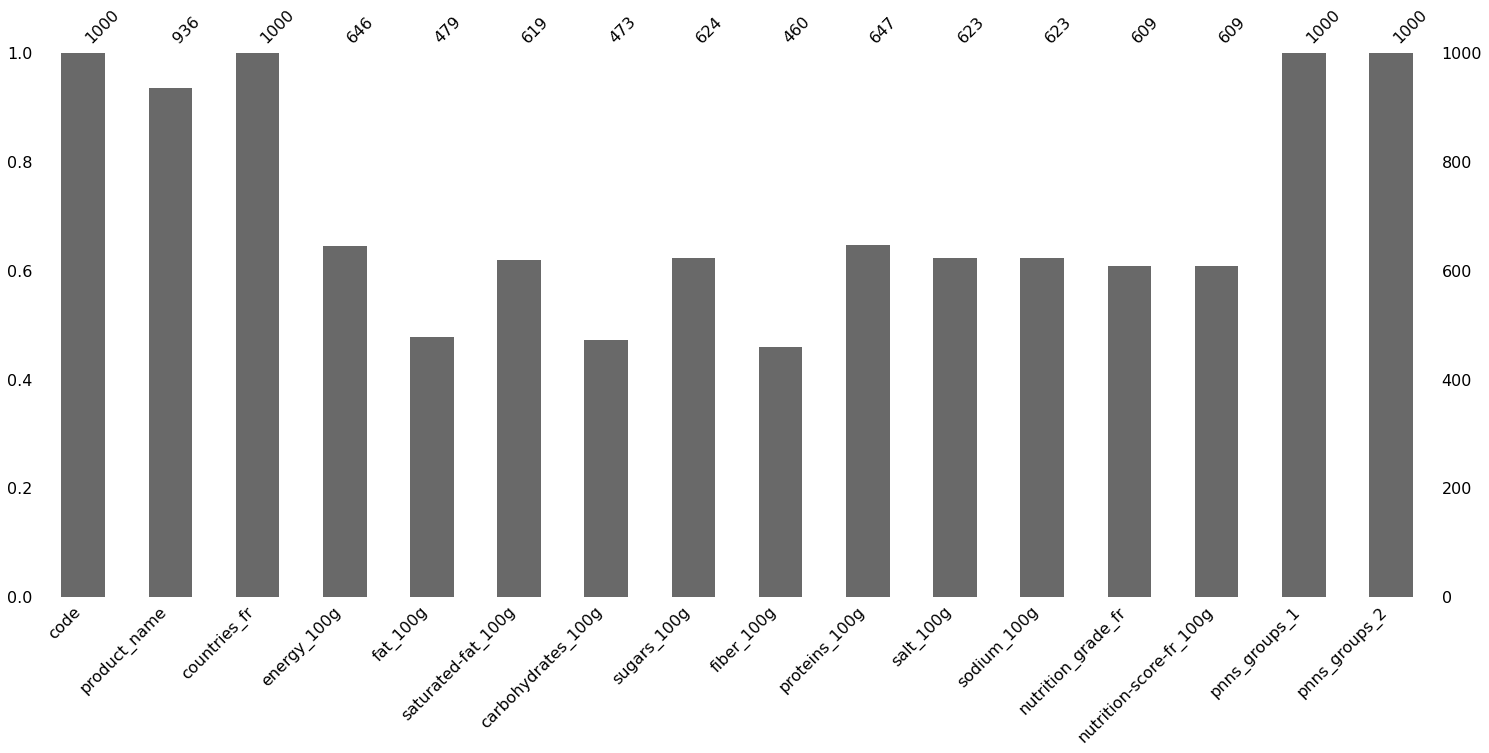

In [51]:
ax=msno.bar(df_food_cleaned.sample(1000))

#### Product_name

 Nous décidons de supprimer tous les produits qui n'ont ni nom, ni catégorie et qui ne pourront donc pas être clairement identifiés.

In [52]:
df_food_cleaned = df_food_cleaned[~((df_food_cleaned.product_name.isnull()) 
                        & ((df_food_cleaned.pnns_groups_1 == "unknown")  | (df_food_cleaned.pnns_groups_2 == "unknown")))]

Recontrollons les valeurs manquantes:

In [53]:
df_food_cleaned['product_name'].isna().sum()

249

Les code etant présents pour pourvoir retrouver les noms de ces produits et la présence de la catégorie les caractériser, nous décidons de remplaçer ces valeurs manquantes par 'unknown'.

In [54]:
df_food_cleaned.loc[df_food_cleaned['product_name'].isna(),'product_name']='unknown'

### Remplissage par un IterativeImputer

Réalisons une analyse de la corrélation linéaire entre les variables quantitatives afin de déterminer les features éligibles à cette méthode d'imputation.

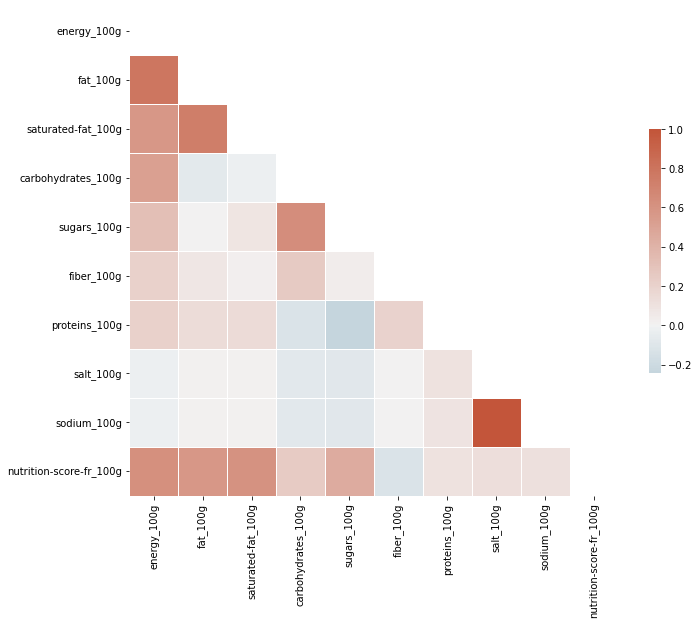

In [55]:
# Calcul de la matrice de corrélation
corr = df_food_cleaned[['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g','nutrition-score-fr_100g']].corr()

# Générer un masque pour le triangle supérieur
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurer la figure matplotlib
f, ax = plt.subplots(figsize=(11, 9))

# Générer une palette de couleurs divergentes personnalisée
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dessiner la carte thermique avec le masque et corriger le format d'image
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Utilissons cette methode d'imputation sur les features 'salt_100g','sodium_100g' très correlées entre elles:

In [56]:
list_corr=['salt_100g','sodium_100g']

Affichons les valeurs manquantes de la liste:

In [57]:
df_food_cleaned[list_corr].isna().sum()

salt_100g      29362
sodium_100g    29363
dtype: int64

Définissons la fonction iterative imputer:

In [58]:
def iterative_imputer(df,liste):
    for i in liste:
        X=df[[i]].values
        imputer = IterativeImputer()
        imputer.fit(X)
        X = imputer.transform(X)
        df[i]=X      

Imputons les valeurs manquantes:

In [59]:
iterative_imputer(df_food_cleaned,list_corr)

Recontrollons les valeurs manquantes de la liste:

In [60]:
df_food_cleaned[list_corr].isna().sum()

salt_100g      0
sodium_100g    0
dtype: int64

### Remplissage par « 0 »

#### Fiber_100g

Nous décidons de remplaçer les  valeurs manquantes par '0' car de nombreux produits ne contiennent pas de fibres.

In [61]:
df_food_cleaned['fiber_100g'].fillna( method ='bfill', inplace = True)

Recontrollons les valeurs manquantes:

In [62]:
df_food_cleaned['fiber_100g'].isna().sum()

0

### Remplissage par KNNImputer

Nous décidons d'imputer avec l'algorithme des K Nearest Neighbours (KNN) les features suivantes:

In [63]:
knn_features = ['sugars_100g', 'proteins_100g', 'carbohydrates_100g']
knn_features

['sugars_100g', 'proteins_100g', 'carbohydrates_100g']

Définissons la fonction d'imputation knn:

In [64]:
def knn_imputer(df,liste):
    # On entraine le modèle d'imputation sur un échantillon de données
    sample_data = df[liste].sample(frac=0.25, random_state=1)
    imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)
    imputer.fit(sample_data)

    # Puis on applique le modèle sur l'ensemble des données
    data_imputed = imputer.transform(df[liste])
    df_data_imputed = pd.DataFrame(data_imputed, columns=knn_features)
    
    for col_knn in liste:
        df[col_knn] = df_data_imputed[col_knn].values
    return df
    

Imputons les données manquantes:

In [65]:
df_food_cleaned=knn_imputer(df_food_cleaned,knn_features)

Recontrollons les valeurs manquantes:

In [66]:
df_food_cleaned[knn_features].isna().sum()

sugars_100g           0
proteins_100g         0
carbohydrates_100g    0
dtype: int64

### Remplissage par la médiane

Nous décidons l'imputation par la mediane sur des données homogénes comme celles par les catégories de produits de la variable pnns_group_1.

Définissons la liste de features dont les valeurs manquantes seront imputer par ma mediane:

In [67]:
liste_med=['energy_100g', 'fat_100g', 'saturated-fat_100g', 'nutrition-score-fr_100g']
liste_med

['energy_100g', 'fat_100g', 'saturated-fat_100g', 'nutrition-score-fr_100g']

Définissons une fonction qui remplace les valeurs manquantes par la valeur la valeur mediane:

In [68]:
def remplissage_median(df,liste,var):
    for col in liste:
        df[col] = df.groupby(var)[col].transform(lambda x: x.fillna(x.median()))

Imputons les valeurs manquantes:

In [69]:
remplissage_median(df_food_cleaned,liste_med,'pnns_groups_1')

Recontrollons les valeurs manquantes:

In [70]:
df_food_cleaned[liste_med].isna().sum()

energy_100g                0
fat_100g                   0
saturated-fat_100g         0
nutrition-score-fr_100g    0
dtype: int64

### Nutrition_grade_fr

Ayant précédemment imputer les valeurs manquantes du nutrition-score,nous pouvons imputer celles du nutrition grade  en calculant le grade correspondant.

Définissons la fonction qui associe des grades correspondant au nutrition score:

In [71]:
def calc_nutrigrade(score):
    if score< 0 :
        nutrigrade = "a"
    elif ((score >= 0) & (score < 5)):
        nutrigrade = "b"
    elif ((score >= 5) & (score < 10)) :
        nutrigrade = "c"
    elif ((score >= 10) & (score < 20)) :
        nutrigrade = "d"
    else:
        nutrigrade = "e"    
    return  nutrigrade

Définissons les indexes des valeurs manquantes:

In [72]:
indexes=df_food_cleaned.loc[df_food_cleaned['nutrition_grade_fr'].isna()].index

Définissons la fonction d'imputation des valeurs manquantes:

In [73]:
def imputation_nutrigrade(df,index,var_1,var_2):
    for i in index:
        score=df.loc[df[var_1].index==i,var_1].iloc[0]
        df.loc[df[var_2].index==i,var_2]=calc_nutrigrade(score)

Imputons les valeurs manquantes:

In [74]:
imputation_nutrigrade(df_food_cleaned,indexes,'nutrition-score-fr_100g','nutrition_grade_fr')

Recontrollons les valeurs manquantes du jeu de données:

In [75]:
df_food_cleaned.isna().sum()

code                       0
product_name               0
countries_fr               0
energy_100g                0
fat_100g                   0
saturated-fat_100g         0
carbohydrates_100g         0
sugars_100g                0
fiber_100g                 0
proteins_100g              0
salt_100g                  0
sodium_100g                0
nutrition_grade_fr         0
nutrition-score-fr_100g    0
pnns_groups_1              0
pnns_groups_2              0
dtype: int64

Réanalysons le jeu de données:

In [76]:
df_food_cleaned.describe()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
count,91481.000000,91481.000000,91481.000000,91481.000000,91481.000000,91481.000000,91481.000000,91481.000000,91481.000000,91481.000000
mean,1091.471283,10.982386,4.485003,27.226128,13.383152,2.579164,7.773364,1.153634,0.456322,8.633377
std,684.132654,12.874655,7.219863,21.200865,15.822079,4.430467,6.611070,3.454363,1.396432,7.818293
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,524.000000,3.200000,0.500000,9.960000,2.100000,0.000000,3.600000,0.170000,0.066929,2.000000
50%,1120.500000,7.800000,2.000000,27.626258,13.208711,1.400000,7.807919,1.153634,0.456322,9.000000
75%,1506.000000,11.700000,5.000000,33.000000,13.208711,3.300000,8.000000,1.153634,0.456322,13.000000
max,3768.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,83.000000,40.000000


Créons un file csv pour la partie exploration des données:

In [77]:
df_food_cleaned.to_csv('df_food_cleaned.csv', sep = '\t',index = False)